# Diffusion and Contagion

In [1]:
%%capture
# Housekeeping
import networkx as nx
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

# Make sure you download econ46_library.py from our course material and save it in the same folder as then notebooks
# this file has some functions specifically coded for the class
from supporting_material import econ46_library as el

# These modules are only to have some interactive pieces of code in the notebooks
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



## Basics

Here are some facts worth highlighting when considering diffusion processes on networks:

- __Key elements__:
    - Set of  initially infected nodes. Are they in the giant component?
        - *We only get notrivial diffusion if someone in the large component gets infected/adopts.*
    - Component Structure. Size of the giant component determines likelihood of diffusion and its extent.

- **Extra flavor:**
    - Time horizon. When trying to disseminate information about a new product or promotion, the information may only be relevant for a fix time.
    - Virality or Probability of Contagion. How likely is the information/disease to spread from an infected node to a non-infected one?
        - If this is extremely close to zero then it could not catch on. However sometimes even contagion with a very small probability can spread across the entire network.
    - Immunity & Vaccination: some people just don't get it, others are protected.
    
    
    

## Component Structure of a Network

Recall that if we have a Network G=(N,E), we can consider a sub-network G' by looking at a subset of the nodes, N', and the set of edges in E that connect them, E'.

Consider now a particular type of subgraphs. We are going to group nodes that are connected with each other. 
- If the network is connected then there's only one group and it accounts for all nodes. 
- If there are no edges in the network then each node is in its own group.

**We are going to call these the "connected components". Get the gist?**

As you have seen, for Erdos-Renyi (ER) random networks the existence and size of components is determined by the wiring  probability (p). It follows naturally, that the probability and extent of contagion will also be a function of this probability.

### Phase Transitions

Recall that for the ER model there are some important values of $p$ for which the behavior of the network changes abruptly. These will be important when thinking about the extent and spread of difussion processes.

- $ p = \frac{1}{n^2}$: the network has some links (avgerage degree = $\frac{1}{n}$).

- $ p = \frac{1}{n^{3/2}}$: the network has a component with at least three links  (avgerage degree = $\frac{1}{n^{1/2}}$).

- $ p = \frac{1}{n}$: the network has a cycle, the network has a unique giant component (avgerage degree = $1$).

- $ p = \frac{\log(n)}{n}$: the network is connected (avgerage degree = $\log(n)$).

Below you can see how for the same number of nodes, the structure is completely different at these threshold values.

**Play with the number of nodes.** Also experiment with looking at values of p just above and just below the thresholds.

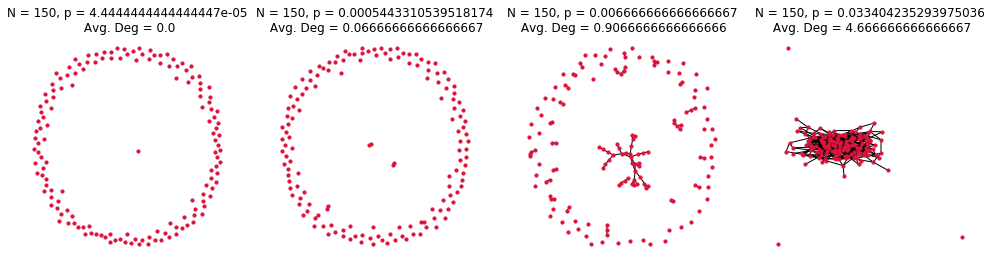

In [2]:
# Let's create a random network, you know the drill
N = 150

# Here we place the different threshold values in a list to iterate through them as we plot the networks.
p_thresholds = [1.0/(N**2), 1.0/(np.sqrt(N**3)), 1/N, np.log(N)/N]

# Create a special plot with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(17, 4))
i = 0 # this is just an index to keep track fo each subplot

# Now we "loop" though the threshold with a "for loop", it takes each value of the least and performs the indented code
for p in p_thresholds: 
    G_thresholds = nx.erdos_renyi_graph(n=N,p=p,seed=34687)
    plt.sca(axes[i]) # calls the subplot
    # Yet another way to plot a network
    nx.draw_spring(G_thresholds,node_color='crimson',
               node_size=10,seed=897462)
    # Add a ttitle
    axes[i].title.set_text('N = {N}, p = {P}\n Avg. Deg = {DEG}'.format(
                            N=N, P=p, DEG=np.mean(list(dict(G_thresholds.degree).values()))))
    i = i+1 # update subplot index
plt.show()


### Connected Components

Now let's take a closer look at how the component structure relates to contagion.

In [3]:
# Yet another random network.
N = 40
p = .016
G_rand = nx.erdos_renyi_graph(n=N,p=p,seed=34545687)


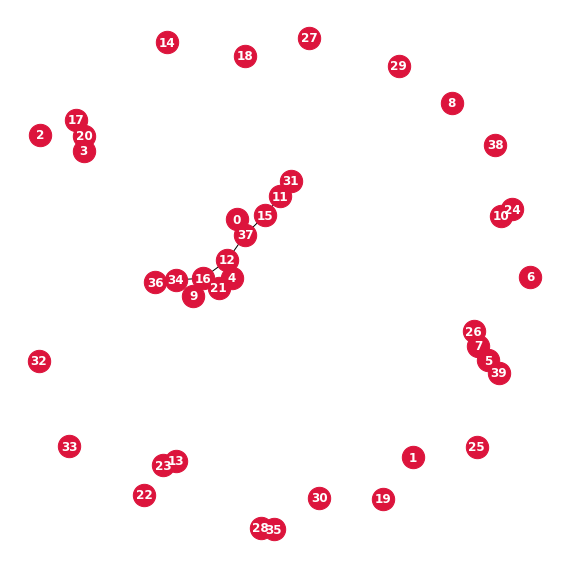

In [4]:
el.plot_simple_graph(G_rand)


### How many connected components?

In [5]:
# Networkx allows us to consider all connected components with the function nx.connected_component_subgraphs(G)

# To handle them better, we will create these components and put them on a list:
list_of_connected_comps = list(nx.connected_component_subgraphs(G_rand))

# How many connected components are in this network?
print("This network has %s connected components." % len(list_of_connected_comps))


This network has 21 connected components.


### How big is the largest component?

Since we placed all connected components in a list, we can readily analyze the largest component by taking the max over the length of the node subset.


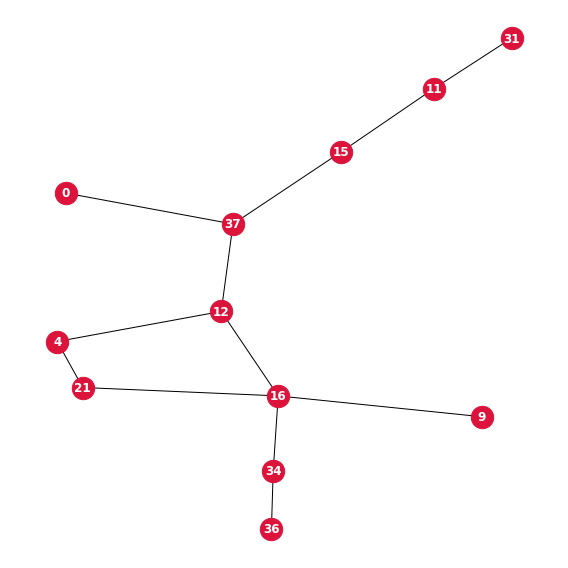

In [6]:
# Consider the largest connected component.
largest_connected_component = max(list_of_connected_comps, key=len)

# Take a look:
el.plot_simple_graph(largest_connected_component)


In [7]:
# Compute and print size of largest component
print("The largest component has %s nodes." % len(largest_connected_component))

# What share of nodes are in the largest component?
q = 1.0*len(largest_connected_component)/N

print("This means that the fraction of nodes in the largest component (referred to as q in lecture) is equal to {FRACTION}.".format(
    FRACTION=q))




The largest component has 12 nodes.
This means that the fraction of nodes in the largest component (referred to as q in lecture) is equal to 0.3.


Recall from class that we can also compute the expected size of the largest component for an Erdos-Renyi random network by solving for q in:

$$1-q = \sum_d (1-q)^d P(d)$$

Because the probability that a node is not in the giant component $(1-q)$ should be equal to the probability that none of the node's "friends" are in the giant component either (it feels like a mouthful but if you think about it it makes intuitive sense).


If we solve this for the Erdos-Renyi Degree distribution (that is if we change that generic probability of degree being equal to d ($P(d)$) for the one that corresponds to the random network generated with the ER model) we get:

$$-\frac{\log(1-q)}{q}  = (n-1)p$$

In [8]:
# Let's see how close is our data to satisfy this equality. 
print("-log(1-q)/q = {LHS}".format(LHS=-np.log(1-q)/q))
print("(n-1)p = {RHS}".format(RHS=(N-1)*p))
# The approximation gets better for larger n and p such that a giant component appears.


-log(1-q)/q = 1.188916479795775
(n-1)p = 0.624



<a id="largest_dense"></a>

This network has 4 connected components.
The largest component has 37 nodes, that's 92.50 percent of its nodes and is below:


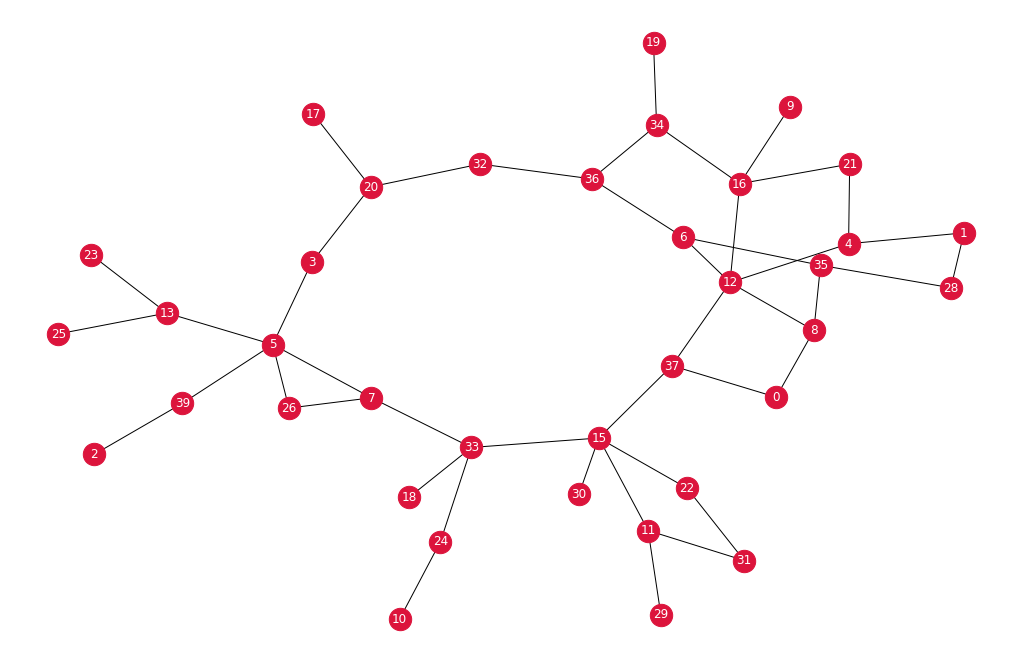

In [9]:
# Let's quickly go through a different example
N2 = 40
p2 = .04
G_rand2 = nx.erdos_renyi_graph(n=N2,p=p2,seed=34545687)
# How many connected components are in this network?
print("This network has %s connected components." % len(list(nx.connected_component_subgraphs(G_rand2))))
# Consider the largest connected component.
largest_cc2 = max(list(nx.connected_component_subgraphs(G_rand2)), key=len)
print("The largest component has %s nodes, that's %0.2f percent of its nodes and is below:" % (len(largest_cc2), 100.0*len(largest_cc2)/N2))

# Another way to plot a network
fig = plt.figure(figsize=(14,9))
nx.draw_kamada_kawai(largest_cc2, with_labels = True,node_color='crimson',node_size=500,font_color='white',seed=897462)
plt.show()

### Why do we care about this?

**Which of these two examples seems more vulnerable to an epidemic, or profitable for a viral campaign?**

Think about this, we went from 34% of the nodes being in the largest component, to 92%.

Now suppose a single node (node 12) is initially infected:

In the first scenario, congation is limited to 12 nodes and nothing changes after the 4th round of diffusion.


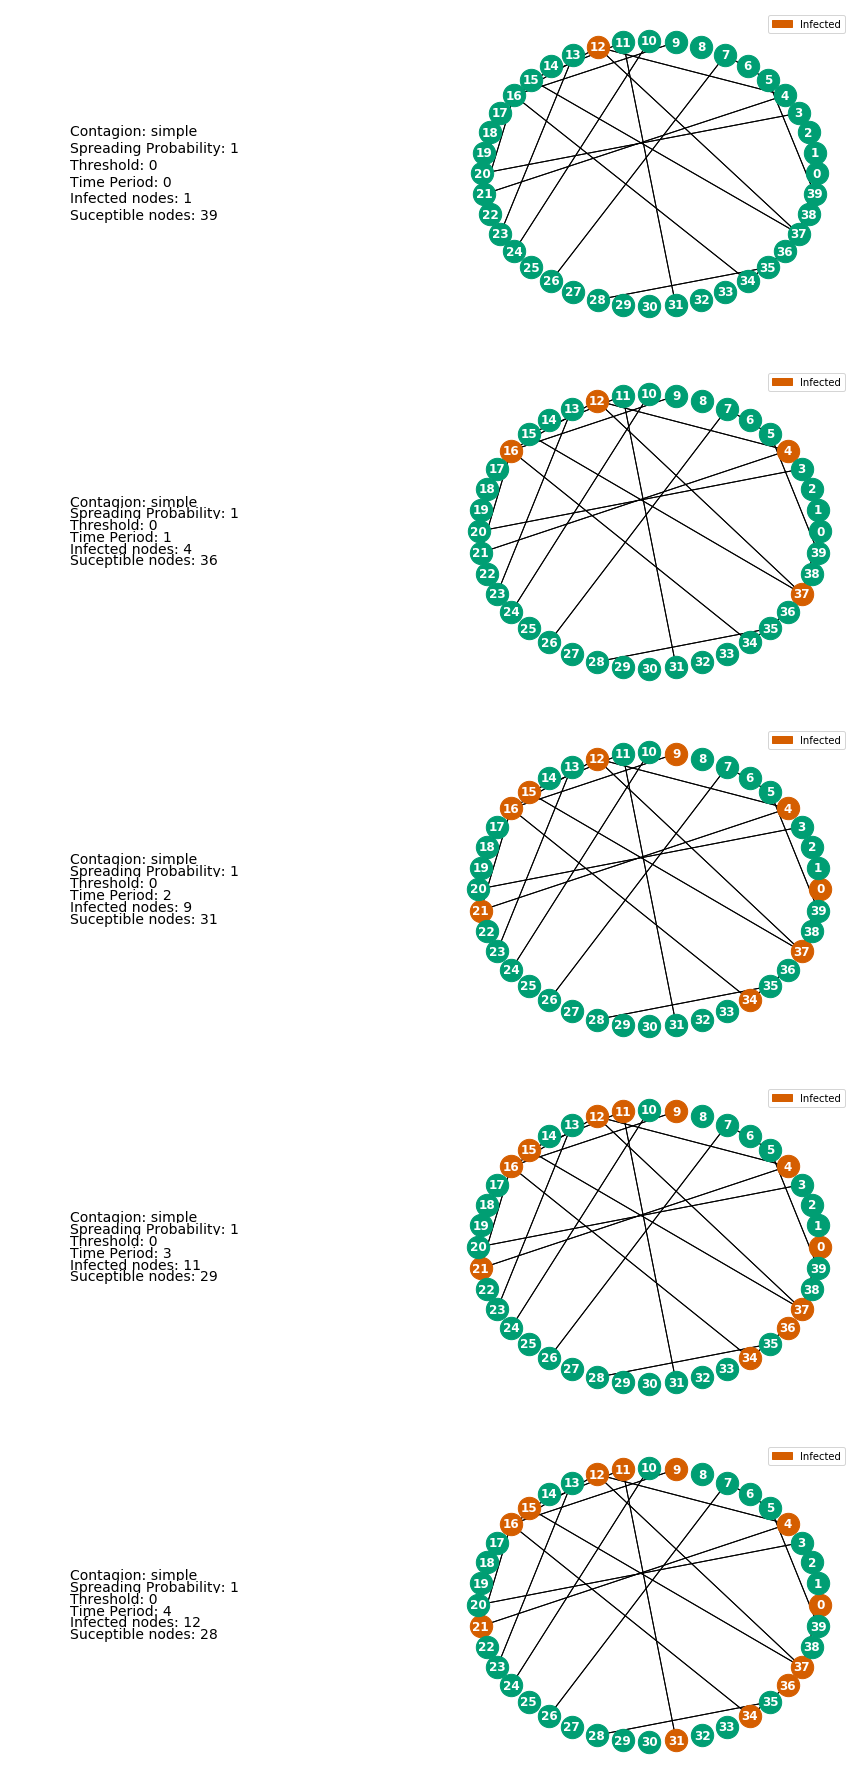

In [10]:
el.contagion(G_rand,initial=[12],T=5)

Now, see how almost everyone has been infected after 5 rounds in the denser network.

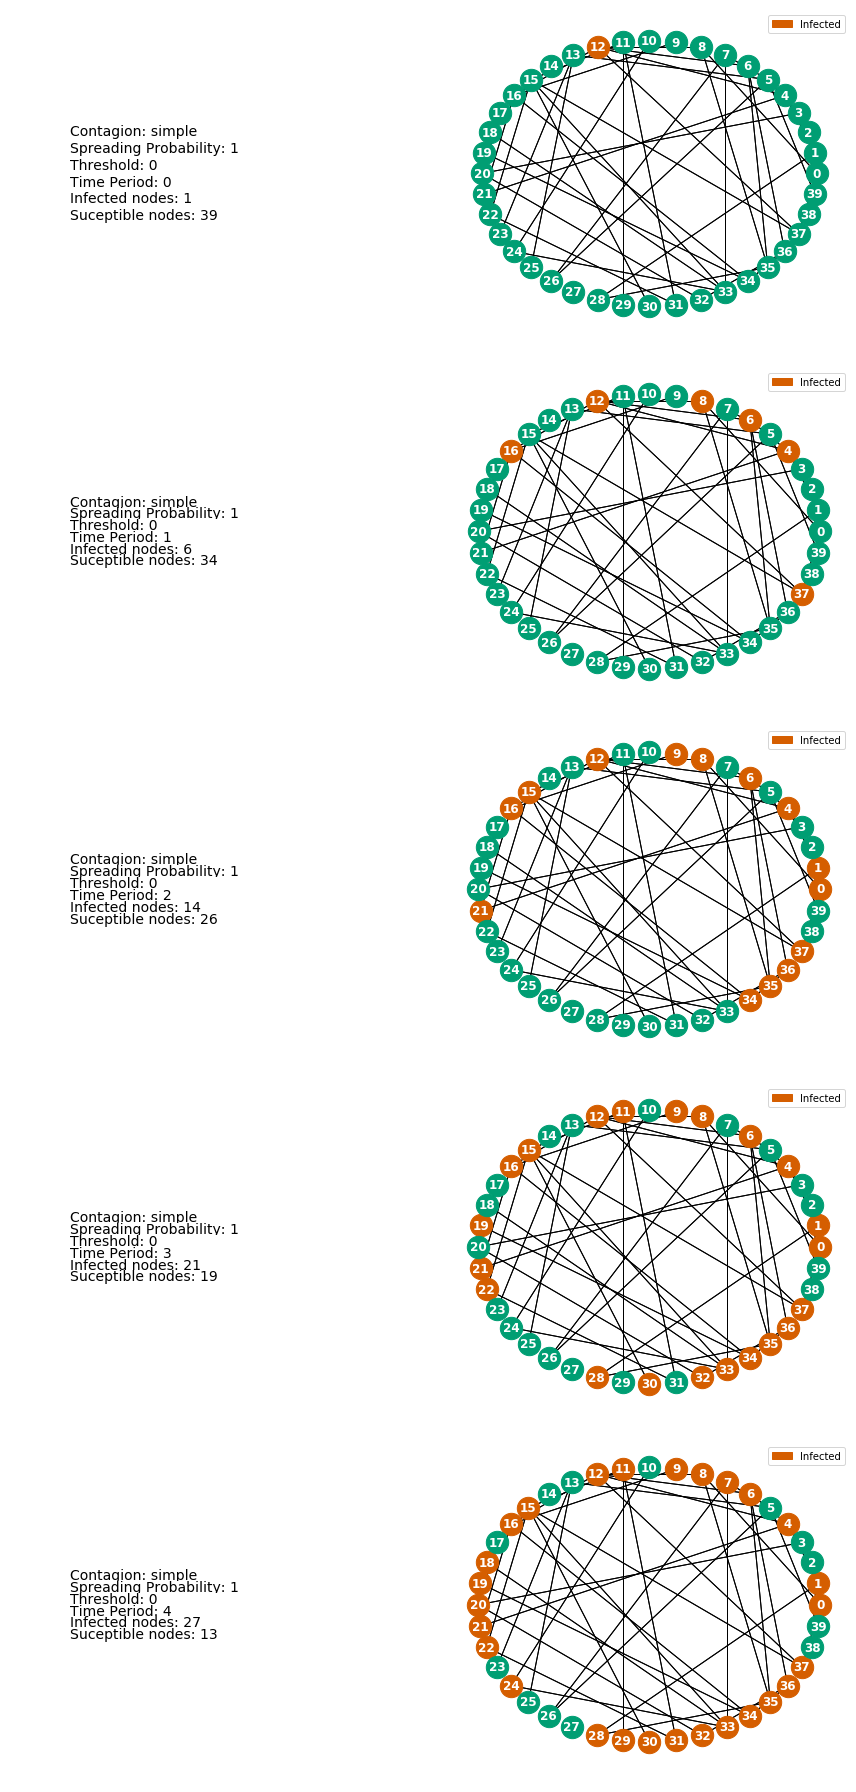

In [11]:
el.contagion(G_rand2,initial=[12],T=5)

## Basic Reproduction Numbers

We will return to the above simulations later.

First, let's consider why some things go "viral" while others don't make a beep; e.g. why was gangam style a global success while Eduardo's dance revolution video only has 5 views (3 of which are from his pets)?

Artistic quality aside, we can start modeling these phenomena with the **Galton-Watson** process you saw in lecture:

- Start with some infected person (video creator).
- That person infects (shares the video) $d_1$ people at random.
- Each subsequent infected person infects (shares the video) $d_i$ people at random too.

Where the number of people $i$ infects ($d_i$) is drawn independently for each person from random distribution P.

For instance, an infected person:
        - Infects (shares with) 0 people with probability 1/4.
        - Infects (shares with) 1 person with probability 1/4.
        - Infects (shares with) 2 person with probability 1/4.
        - Infects (shares with) 3 person with probability 1/4.
       
See the class slides for a graphic representation of this precise example.

**Note that as long as the probability of infecting 0 (not sharing) is positive, then the process can stop right away and at any given level.**

The more the number of infections (shares) grows, the more chances it has to survive.

As you saw in class, if on average infected people spread it to less than 1 person ($E[d_i]<1$), then the process will eventually end with probability equal to one. Intuitively it shrinks until no one infects (shares).

If the average person infects (shares) to more than 1 ($E[d_i]>1$), then the probability of stopping is less than one.


Let's look at a simulation below:

In [15]:
# First, a function to draw di 
def gw_infection_distribution(values, probabilities):
    """ This function takes a list of values for di and the probabilities with
        which this values appear.
        Input: 
            - values: list with support for random variable e.g. [0,1,2,3,4]
            - probabilities: list with probability for each value of support. e.g. [0.0246,.9525,.0217,.0012]
        Returns:
            - di: a random draw from the values list according to the probabilities list.
    """
    if len(values)!=len(probabilities):
        print("Values and probabilities lists must have the same length.")
        return
    cumulative_prob = np.cumsum(probabilities)
    if np.sum(probabilities)!=1 or np.min(probabilities)<0:
        print("Not a valid probability distirbution")
        return
    u = np.random.uniform()
    for i in range(len(values)):
        if u < cumulative_prob[i]:
            d = values[i]
            return d    
    print('Error, no value found')
    
    

def viral_process(values,probabilities,vaccination_rate=0,max_num_iter = 1000):
    """ This function simulates a Galton-Watson viral process.
        Input: 
            - values: list with potential contagion numbers e.g. [0,1,2,3,4]
            - probabilities: list with probability for each number of infected "friends". e.g. [0.0246,.9525,.0217,.0012]
            - vaccination_rate: [default=0] share of the nodes that are immune to infection.
            - max_num_iter: [default=1000] maximum number of steps allowed so the computer does not go
            into an infinite loop
        Returns:
            Prints . for each infected node at each step. 
            Prints the length of the infection chain before extinction.
    """
    # We start in step 0 with 1 infected person.
    k = 0
    dk = 1
    
    if vaccination_rate>1 or vaccination_rate<0:
        print('Vaccination rate has to be between zero and one.')
        return

    # And we iterate until the process goes to extinction 
    # (or if it gets too long so that  your computer does not go crazy)
    while dk > 0:
        d = 0
        for node in range(dk):
            d = d + gw_infection_distribution(values, probabilities)
        
        dk = int(np.ceil((1-vaccination_rate)*d))
        print(dk*'.')
        k  = k + 1
        if k >max_num_iter:
            print('Exceeded maximum number of iterations!')
            break
    print('\n The process went along for %s steps' % k)
    

In [16]:
# Now let's simulate,
# Choose the probability distribution for how many people will be infected by an already infected node: 
values= [0,1,2,3]
probabilities = [0.0246,.9525,.0217,.0012]
 #[0.0245,.6525,.321,.002] #[0.0246,.9525,.0217,.0012]

viral_process(values,probabilities,)

.
.
.
.
.
.
.
.
.
.


 The process went along for 11 steps


Sometimes, nodes are immune to the diffusion process and do not pass along the information/disease.

Consider what happens in the denser network when nodes 6, 16 and 37 have been vaccinated or are immune.

The diffusion process is halted after 4 rounds and spreads only locally.

Of course, I chose to vaccinate a very specific set of nodes. Go back to the [plot of the largest component of the dense network](#largest_dense) and look at the position of node 12 as well as of nodes 6, 16 and 37. 

**What happens when you dont know who is initially infected, who would you vaccinate?**


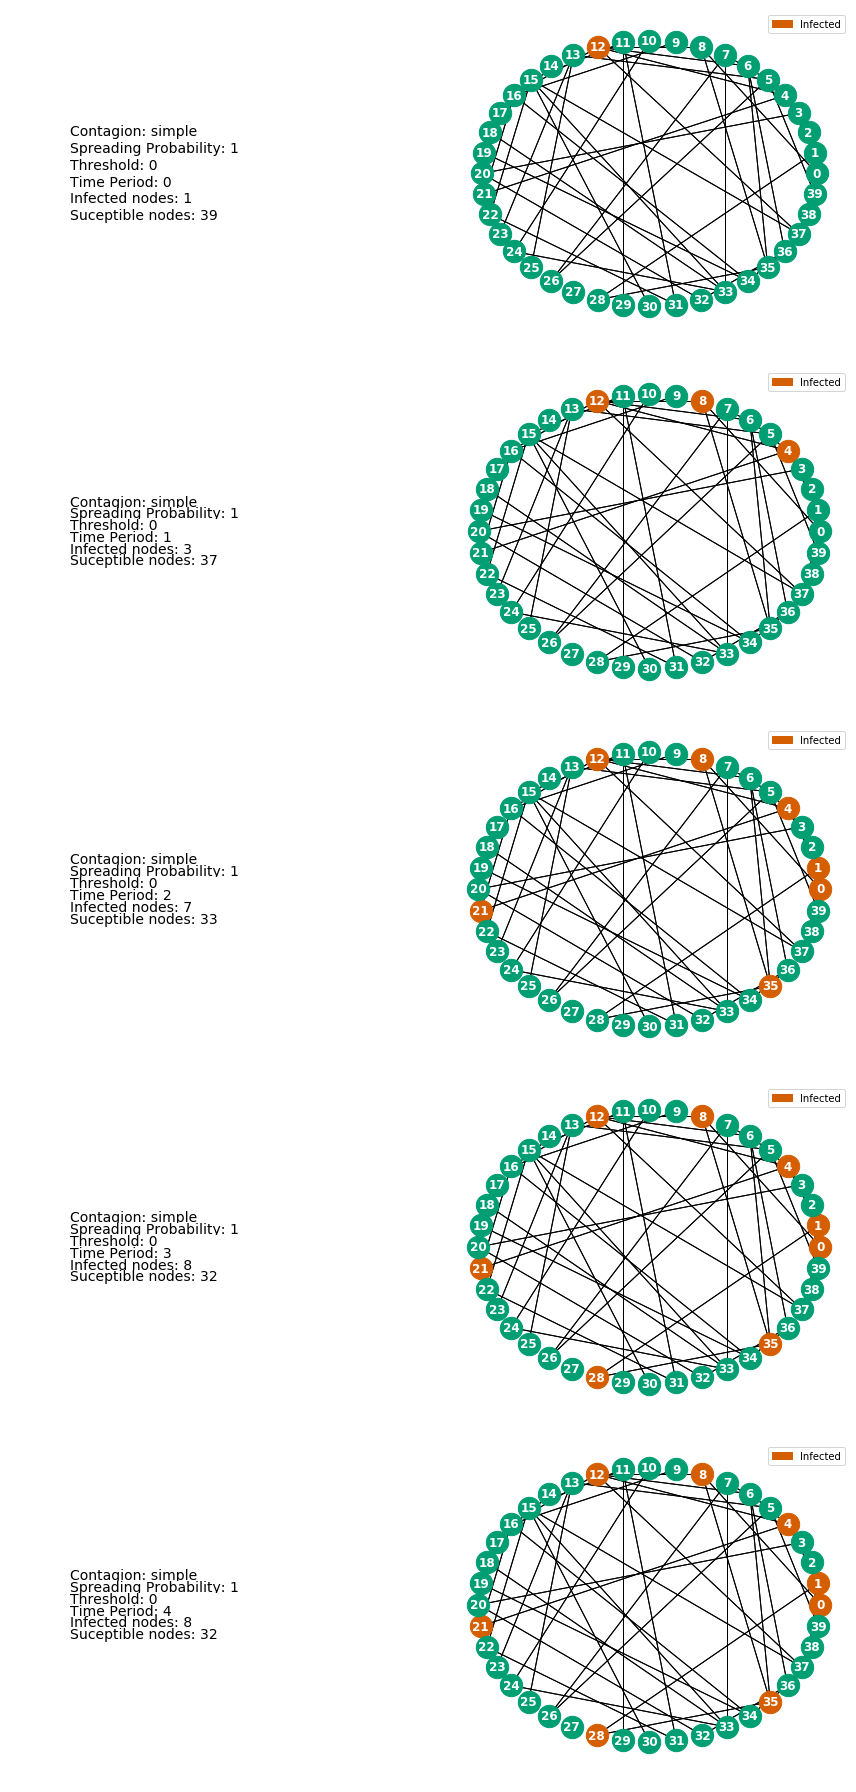

In [17]:
el.contagion(G_rand2,initial=[12],vaccinated=[6,16,37],T=5)

# Extra material [OPTIONAL read]

### Real world flu: random sickness or network contagion?

Now we will explore a real-life network.

Nodes are colored to reflect the presence of flu symptoms during 14 weeks.

If instead of the actual flu status, we randomly reassign the "sick" label in the network (e.g. in the first week we asign 3 nodes to be sick and the rest to be non-sick, in the second week we randlomly assign 6 nodes to be sick, and so on) and count how many sick people have sick connections, then we can get an idea of how likely is for flu to appear among friends only by chance and not because of the friendship.

If we repeat this simulation exercise many times we learn how likely this happens by chance. That is we learn the distribution of "sick-pairs" when the world is such that flu is not really contagious, it just happens randomly to each individual with a different probability each week.

The outcome of such simulation is summarized the distribution on the right panels below.

Finally, if we look at how many sick people have sick connections in the real data (the red dashed line in the panel) then we can test whether the flu seems like it appears randomly and independently in the network or if the presence of symptoms is correlated in the network. The smaller the value in the vertical axis at which the dashed line crosses the solid line, the less likely is our  model "flu-happens-randomly-and-independently".

For this dataset, it seems like the correlation in the network is high for some weeks and low for others. For the first week it seems like the network is irrelevant. For weeks 9 and 14 however, the observed behavior would appear less than 5% of the times in a "flu-happens-randomly-and-independently" world.


Uncomment code below and run the simulation

Running simulation . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

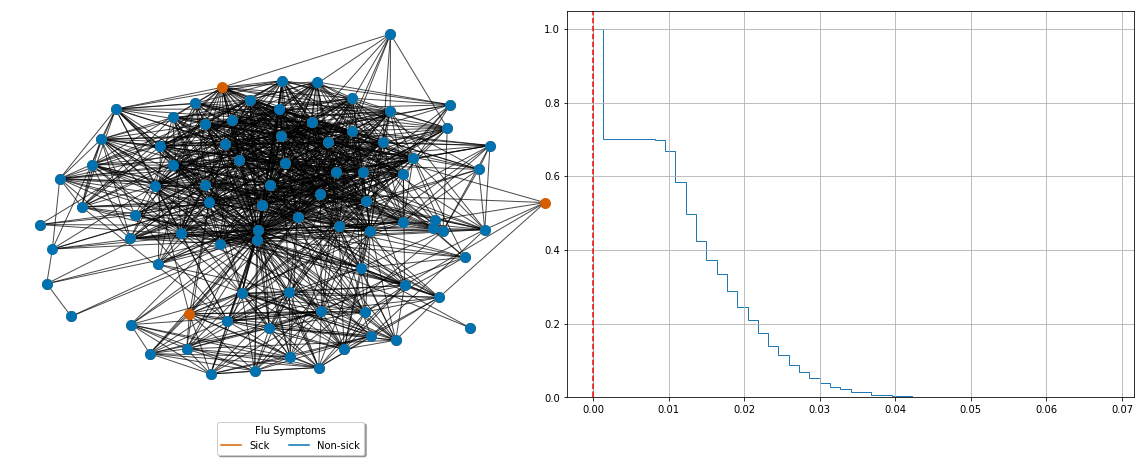

2009-01-12/2009-01-18


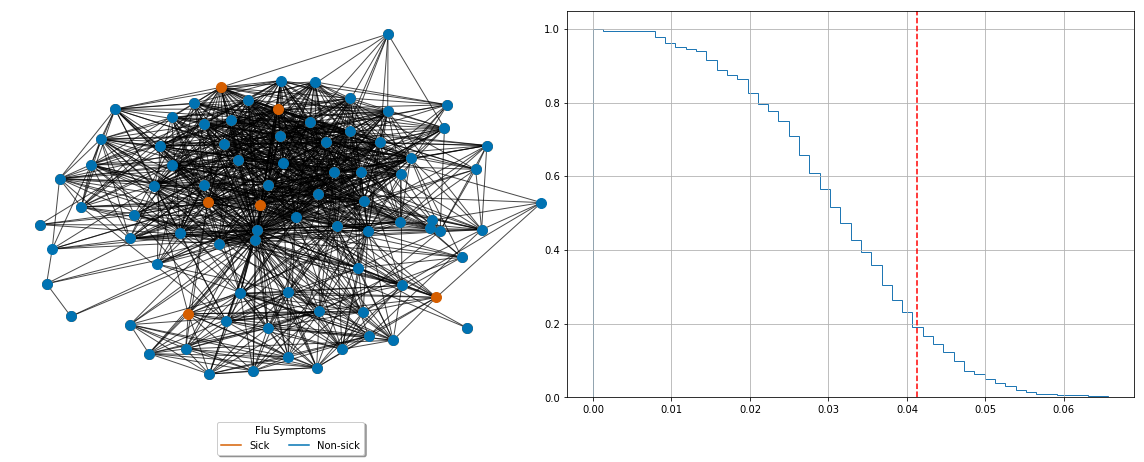

2009-01-19/2009-01-25


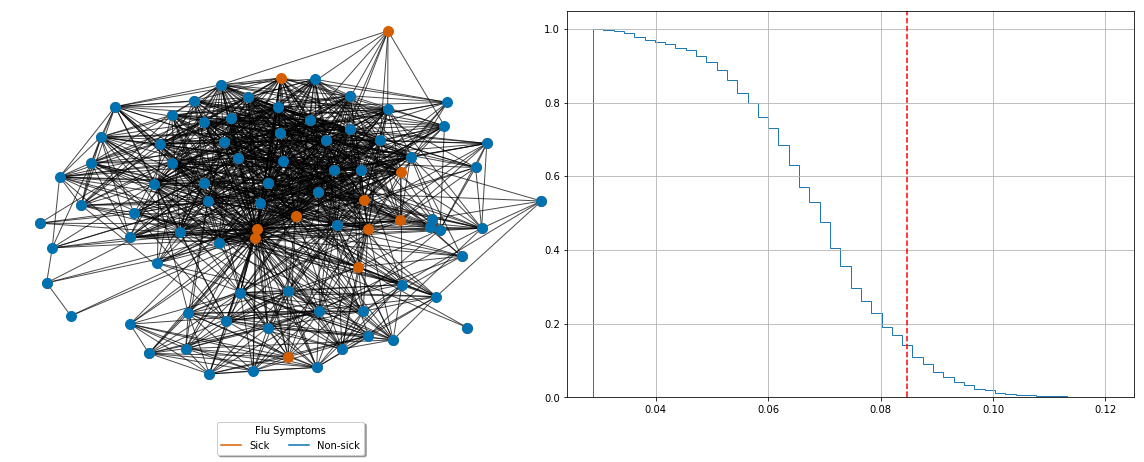

2009-01-26/2009-02-01


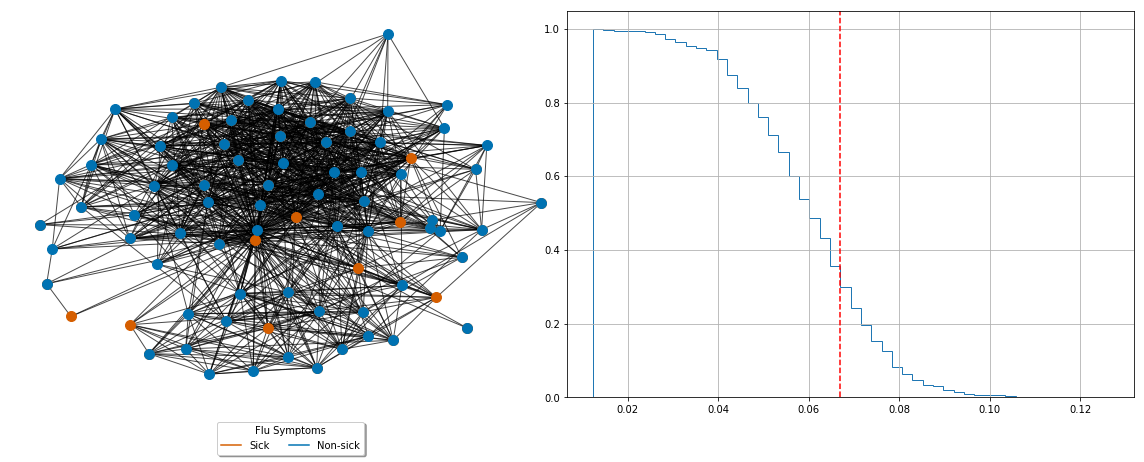

2009-02-02/2009-02-08


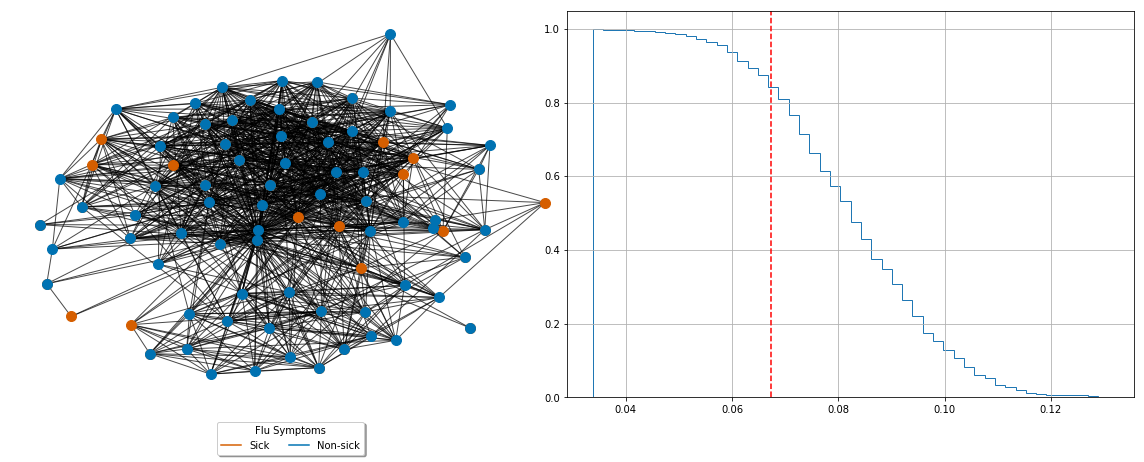

2009-02-09/2009-02-15


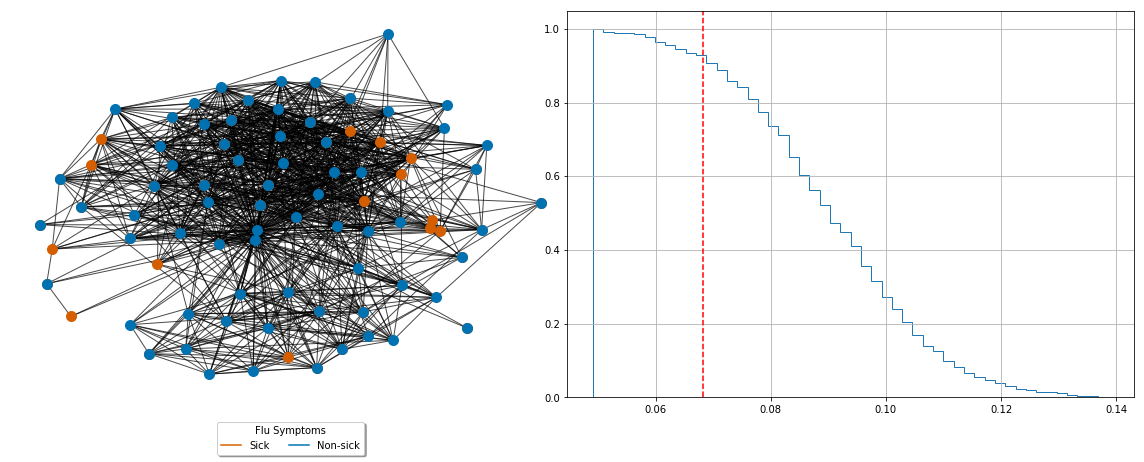

2009-02-16/2009-02-22


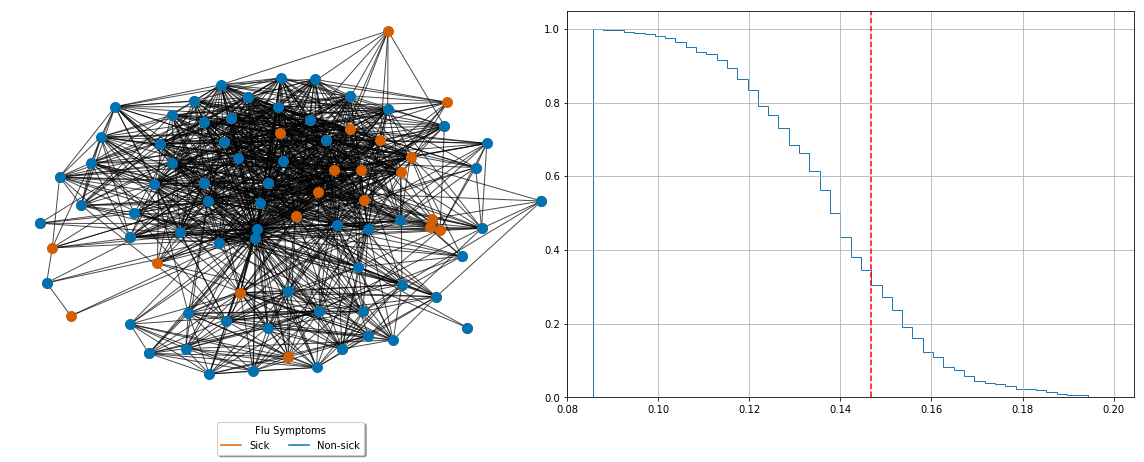

2009-02-23/2009-03-01


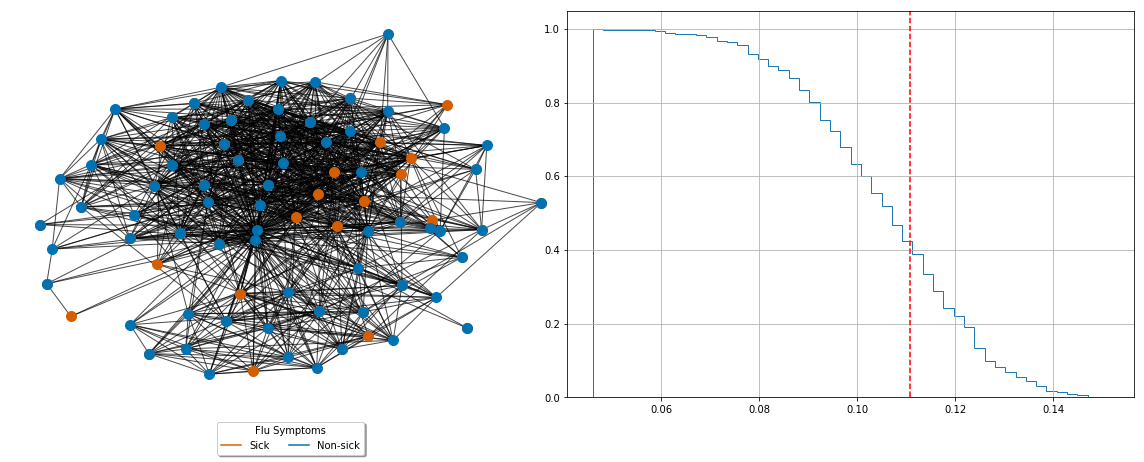

2009-03-02/2009-03-08


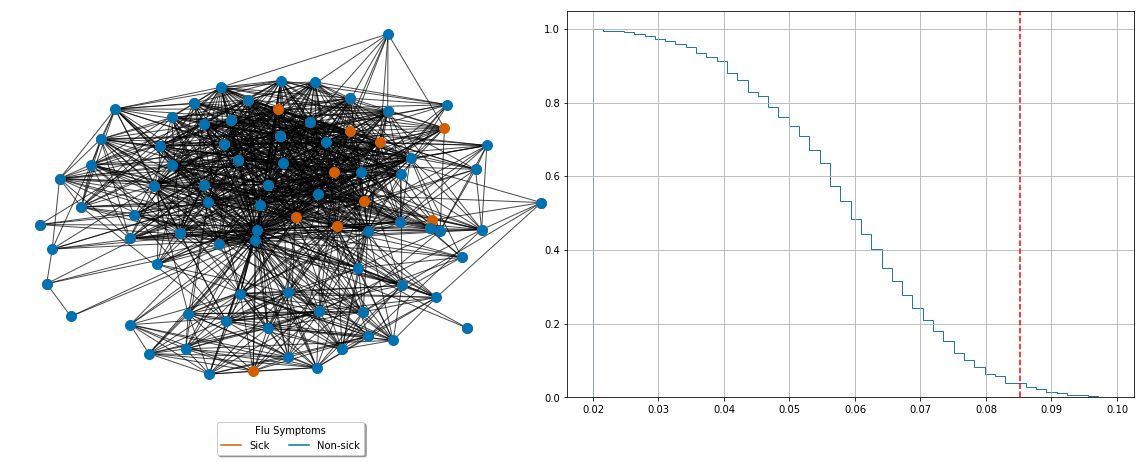

2009-03-09/2009-03-15


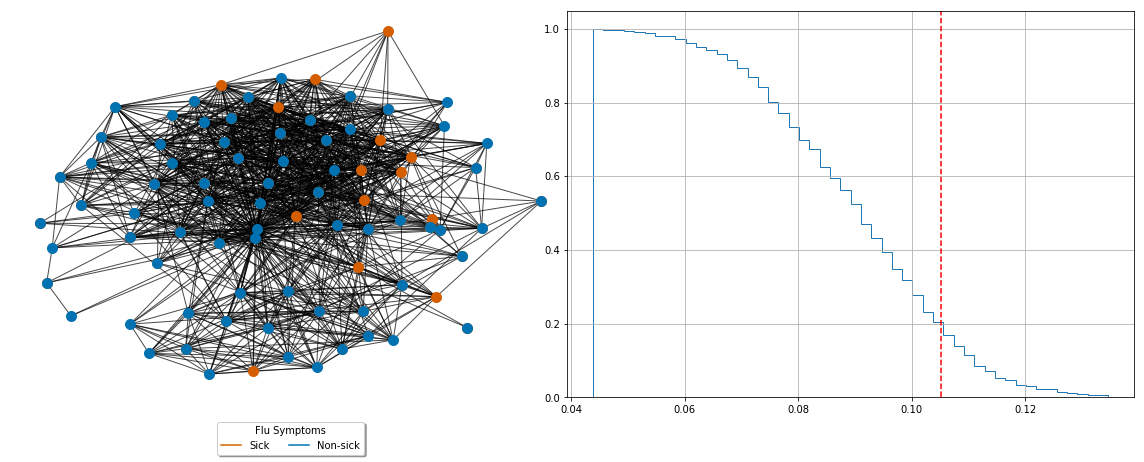

2009-03-16/2009-03-22


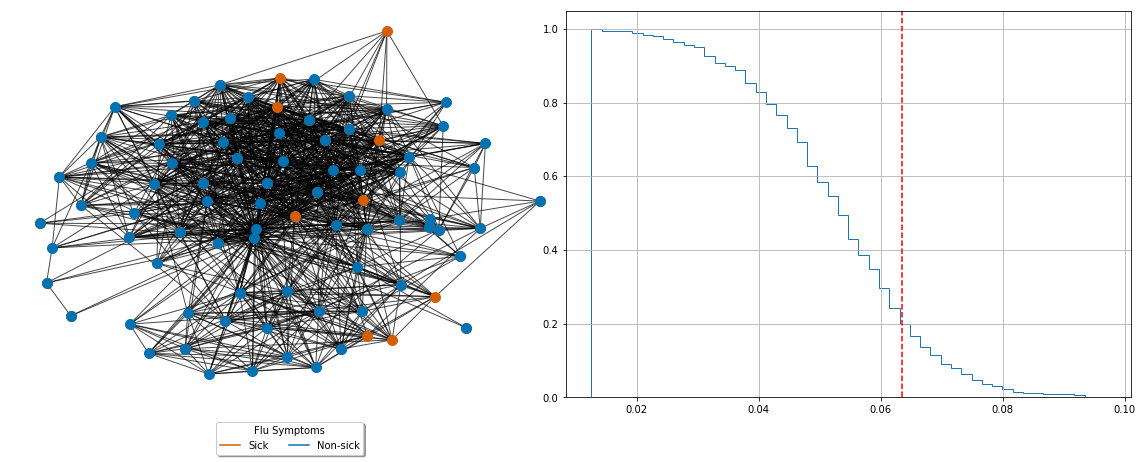

2009-03-23/2009-03-29


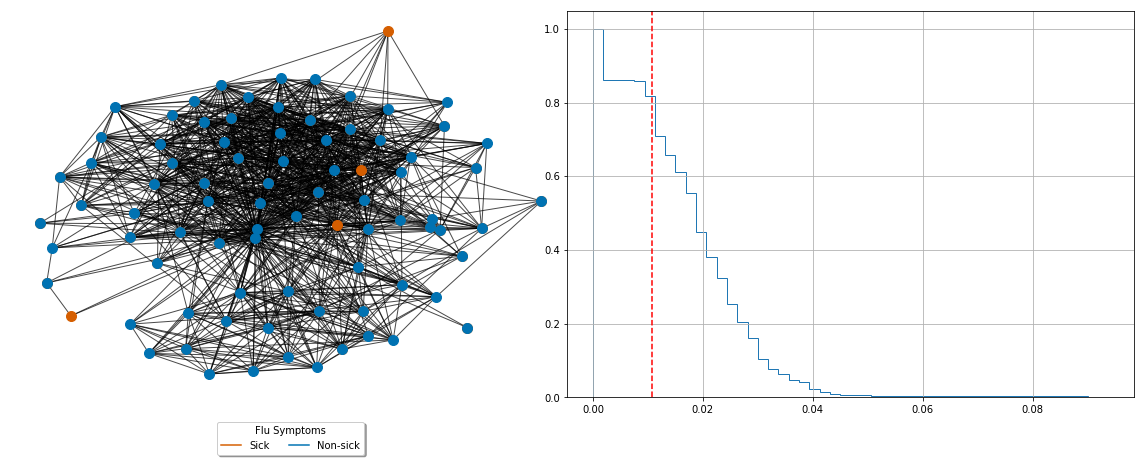

2009-03-30/2009-04-05


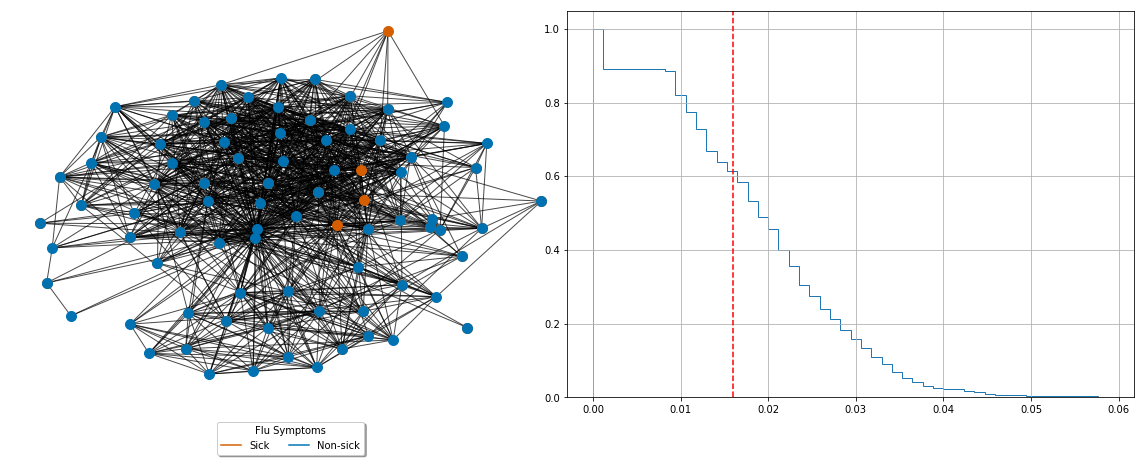

2009-04-06/2009-04-12


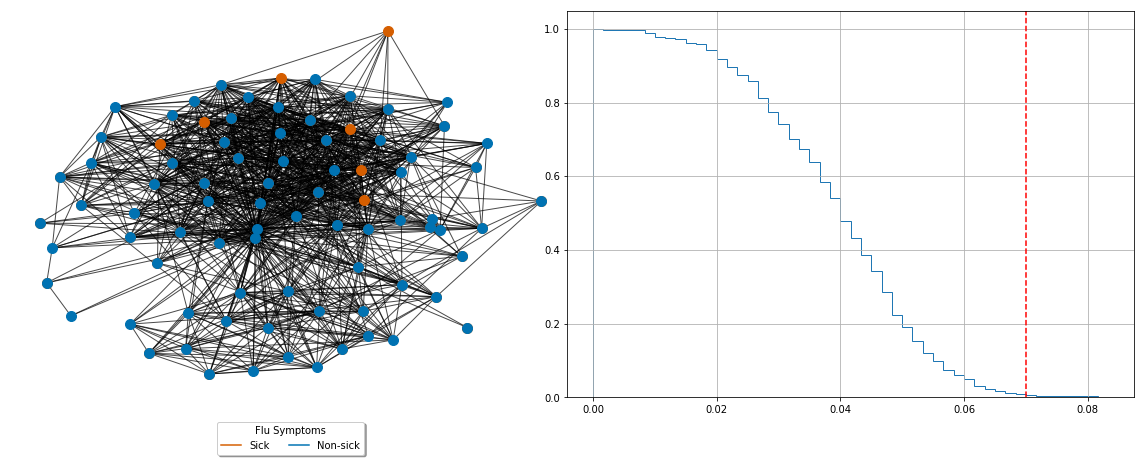

In [18]:
el.real_flu_contagion_with_pval()